# Try to recover performance on unlearned task adversarially

In [1]:
%load_ext autoreload
%autoreload 2
import os
import sys
sys.path.append('acdcpp/Automatic-Circuit-Discovery/')
sys.path.append('acdcpp/')
from acdc import TLACDCExperiment
from acdcpp.ACDCPPExperiment import ACDCPPExperiment

import os
import sys
import re

# import acdc
from acdc.TLACDCExperiment import TLACDCExperiment
from acdc.acdc_utils import TorchIndex, EdgeType
import numpy as np
import torch as t
from torch import Tensor
import einops
import itertools

from transformer_lens import HookedTransformer, ActivationCache

import tqdm.notebook as tqdm
import plotly
from rich import print as rprint
from rich.table import Table

from jaxtyping import Float, Bool
from typing import Callable, Tuple, Union, Dict, Optional

import torch
import pickle

device = t.device('cuda') if t.cuda.is_available() else t.device('cpu')
print(f'Device: {device}')

Device: cuda


## First, load model back in

In [2]:
edge_masks = False
use_uniform = False
ioi_uniform_type = "IO_S"
weight_masks_attn = True
weight_masks_mlp = True
train_base_weights = False
localize_acdcpp = True

run_name = f"{use_uniform=}_"
if use_uniform:
    run_name += f"_{ioi_uniform_type=}_"
run_name += f"{edge_masks=}_{weight_masks_attn=}_{weight_masks_mlp=}_{train_base_weights=}_{localize_acdcpp=}"

epoch = 200
# want to open masks/{run_name}/mask_params_epoch=200.pt
mask_params_path = f'masks/{run_name}/mask_params_epoch={epoch}.pt'
mask_params = torch.load(mask_params_path, map_location=device)

In [3]:
from cb_utils.models import load_demo_gpt2, tokenizer
model = load_demo_gpt2(means=False, edge_masks=edge_masks, weight_masks_attn=weight_masks_attn, weight_masks_mlp=weight_masks_mlp, train_base_weights=train_base_weights)
from tasks import IOITask
task = IOITask(batch_size=16, tokenizer=tokenizer, device=device)
print(task.get_test_accuracy(model))

Using device: cuda:0
1.0


In [4]:
# load mask params into model
for k, v in model.named_parameters():
    if v.requires_grad:
        mask = mask_params.pop(0)
        v.data = mask

IndexError: pop from empty list

In [ ]:
task = IOITask(batch_size=16, tokenizer=tokenizer, device=device)
print(task.get_test_accuracy(model))

0.625


In [ ]:
# try finetuning model (finetune only weights), for now only finetune the attention and mlps
from torch.optim import AdamW
from cb_utils.learn_mask import train_masks

for name, param in model.named_parameters():
    if "attn.W_Q" in name or "attn.W_K" in name or "attn.W_V" in name or "attn.W_O" in name or "mlp.W_in" in name or "mlp.W_out" in name:
        param.requires_grad = True
    elif "attn.b_Q" in name or "attn.b_K" in name or "attn.b_V" in name or "attn.b_O" in name or "mlp.b_in" in name or "mlp.b_out" in name:
        param.requires_grad = True
    else:
        param.requires_grad = False

In [ ]:
# make param_names, mask_params
param_names = [n for n, p in model.named_parameters() if p.requires_grad]
mask_params = [p for n, p in model.named_parameters() if p.requires_grad]

lr = 1e-2
weight_decay = .1
optimizer = torch.optim.AdamW(mask_params, lr=lr, weight_decay=weight_decay)

In [ ]:
from tasks import IOITask, OWTTask
owt_task = OWTTask(batch_size=16, tokenizer=tokenizer, device=device)
# train_tasks = {"ioi": task, "owt": owt_task}
# task_weights = {"ioi": 1.0, "owt": 1.0}
train_tasks = {"ioi": task}
task_weights = {"ioi": 1.0}
# eval_tasks = {"ioi": task}
eval_tasks = {"ioi": task, "owt": owt_task}
train_losses, test_losses = train_masks(
    model,
    optimizer=optimizer,
    tasks=train_tasks,
    task_weights=task_weights,
    eval_tasks=eval_tasks,
    num_epochs=100,
    param_names=param_names,
    mask_params=mask_params,
    steps_per_epoch=10,
    evaluate_every=2,
    num_eval_steps=10,
    discretize_every=None,
    save_every=None,
)

/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/datasets/table.py:1421: FutureWarning: promote has been superseded by mode='default'.
  table = cls._concat_blocks(blocks, axis=0)
100%|██████████| 11/11 [00:17<00:00,  1.60s/it]


In [ ]:
test_losses.keys()

dict_keys(['ioi', 'ioi_acc', 'owt', 'owt_acc'])

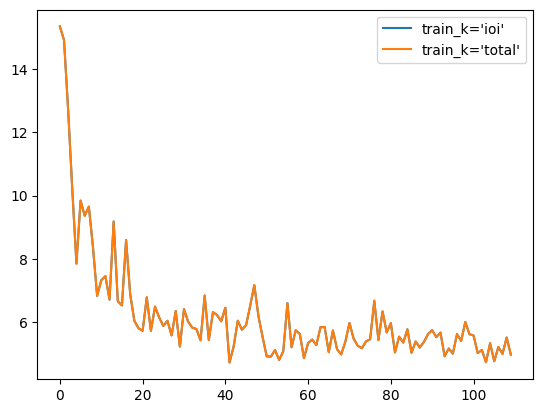

In [ ]:
# plot train_losses, test_losses
import matplotlib.pyplot as plt

for k, v in train_losses.items():
    plt.plot([x[2] for x in v], label=f"train_{k=}")
plt.legend()
plt.show()


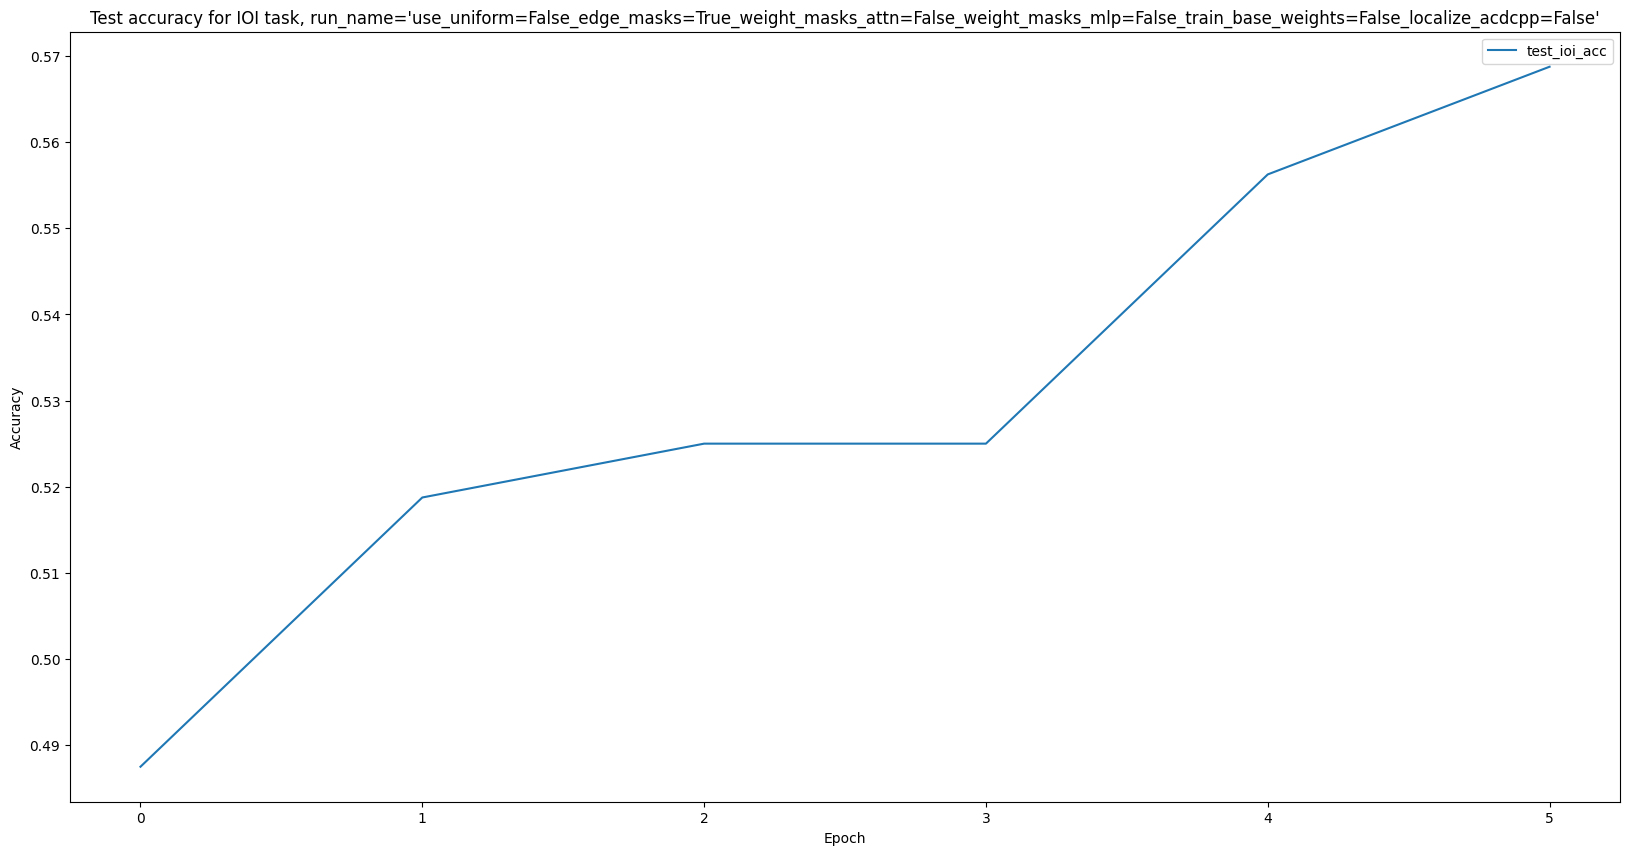

In [ ]:
# plt.plot([x.item() for x in test_losses["ioi"]], label="test_ioi_loss")
# plot make figure size
plt.figure(figsize=(20, 10))
plt.title(f"Test accuracy for IOI task, {run_name=}")
plt.plot([x for x in test_losses["ioi_acc"]], label="test_ioi_acc")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend()
plt.show()

In [ ]:
model.blocks[8].edge_mask_attentions

Parameter containing:
tensor([[1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        ...,
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.]], device='cuda:0', requires_grad=True)

In [ ]:
print((model.blocks[11].edge_mask_attentions == 0).sum())

tensor(0, device='cuda:0')


In [ ]:
model.blocks[11].edge_mask_attentions

Parameter containing:
tensor([[1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        ...,
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.]], device='cuda:0')

In [ ]:
for name, param in model.named_parameters():
    print(name, param.requires_grad)

output_mask True
embed.W_E False
pos_embed.W_pos False
ln_final.w False
ln_final.b False
unembed.W_U False
unembed.b_U False
blocks.0.edge_mask_attentions True
blocks.0.edge_mask_mlp True
blocks.0.ln1.w False
blocks.0.ln1.b False
blocks.0.attn.W_Q False
blocks.0.attn.b_Q False
blocks.0.attn.W_K False
blocks.0.attn.b_K False
blocks.0.attn.W_V False
blocks.0.attn.b_V False
blocks.0.attn.W_O False
blocks.0.attn.b_O False
blocks.0.ln2.w False
blocks.0.ln2.b False
blocks.0.mlp.W_in False
blocks.0.mlp.b_in False
blocks.0.mlp.W_out False
blocks.0.mlp.b_out False
blocks.1.edge_mask_attentions True
blocks.1.edge_mask_mlp True
blocks.1.ln1.w False
blocks.1.ln1.b False
blocks.1.attn.W_Q False
blocks.1.attn.b_Q False
blocks.1.attn.W_K False
blocks.1.attn.b_K False
blocks.1.attn.W_V False
blocks.1.attn.b_V False
blocks.1.attn.W_O False
blocks.1.attn.b_O False
blocks.1.ln2.w False
blocks.1.ln2.b False
blocks.1.mlp.W_in False
blocks.1.mlp.b_in False
blocks.1.mlp.W_out False
blocks.1.mlp.b_out False
b